## Redes Neuronales - Trabajo Practico N°1 - Clasificación Multiclase
### Dataset Yeast 
es un dataset para construir un predictor de sitios específicos de anclaje de proteínas de levaduras basado en información de las secuencias de aminoácidos que forman a la proteína (problema de clasificación multiclase).

In [1]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
import pandas as pd
import src.functions as nn
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Sequential #Para poder definir un modelo secuencial
from keras.layers import Dense, BatchNormalization #Para poder usar capas densas
from keras.optimizers import SGD, Adam
#import src.helper as helper
#import src.multiclass_helper as mc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.random.set_seed(42)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
columns = ["mcg","gvh","alm","mit","erl","pox","vac","nuc"]
df = pd.read_csv("data/yeast.data",names = ["Name"] + columns + ["Class"], sep='\s+')

### Análisis exploratorio de datos (EDA)


In [4]:
df

Name   mcg   gvh   alm   mit  erl  pox   vac   nuc Class
0     ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22   MIT
1     ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22   MIT
2     ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22   MIT
3     AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22   NUC
4     AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22   MIT
...          ...   ...   ...   ...   ...  ...  ...   ...   ...   ...
1479  YUR1_YEAST  0.81  0.62  0.43  0.17  0.5  0.0  0.53  0.22   ME2
1480  ZIP1_YEAST  0.47  0.43  0.61  0.40  0.5  0.0  0.48  0.47   NUC
1481  ZNRP_YEAST  0.67  0.57  0.36  0.19  0.5  0.0  0.56  0.22   ME2
1482  ZUO1_YEAST  0.43  0.40  0.60  0.16  0.5  0.0  0.53  0.39   NUC
1483  G6PD_YEAST  0.65  0.54  0.54  0.13  0.5  0.0  0.53  0.22   CYT

[1484 rows x 10 columns]

#### Balance de clases

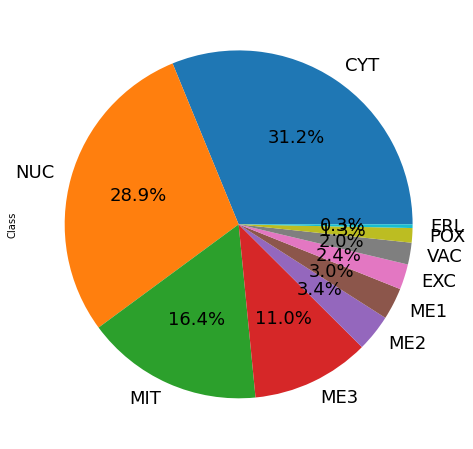

In [5]:
clases = df["Class"].drop_duplicates().to_list()

plot = df['Class'].value_counts().plot( kind='pie', autopct="%.1f%%", fontsize=18, figsize=(8, 8))

A continuación grafico un histograma de cada feature con un kernel density encimado y un boxplot para tener una idea de los valores atipicos por feature. Además abajo comparo los kernel density de cada feature por clase para ver su distribución y darse una idea de la distinción entre clases.

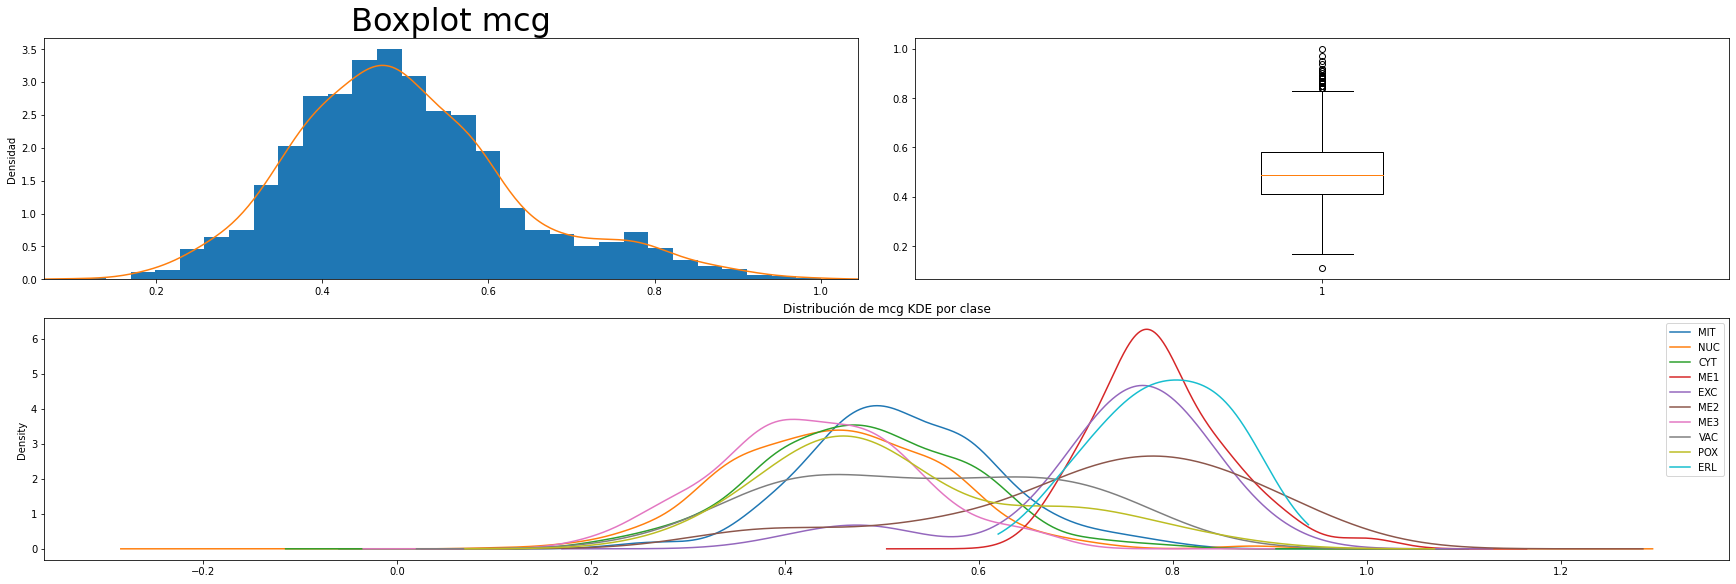

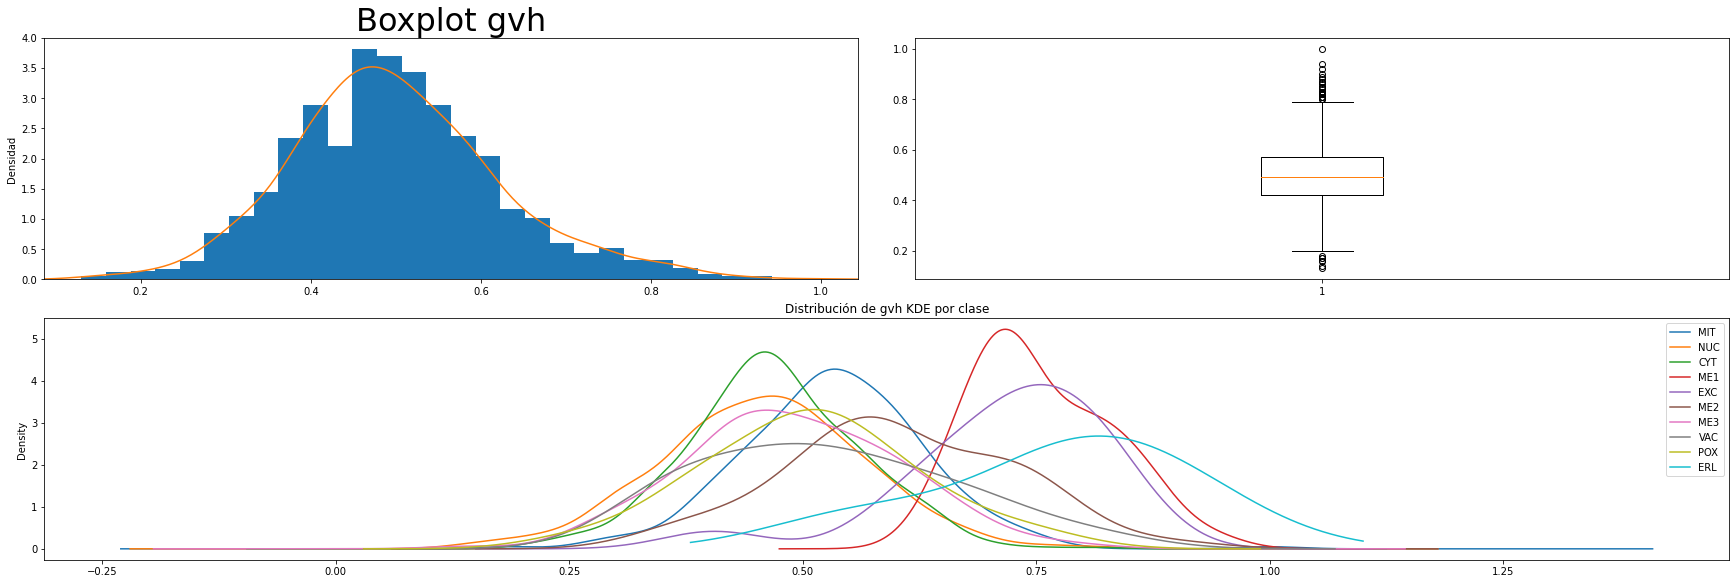

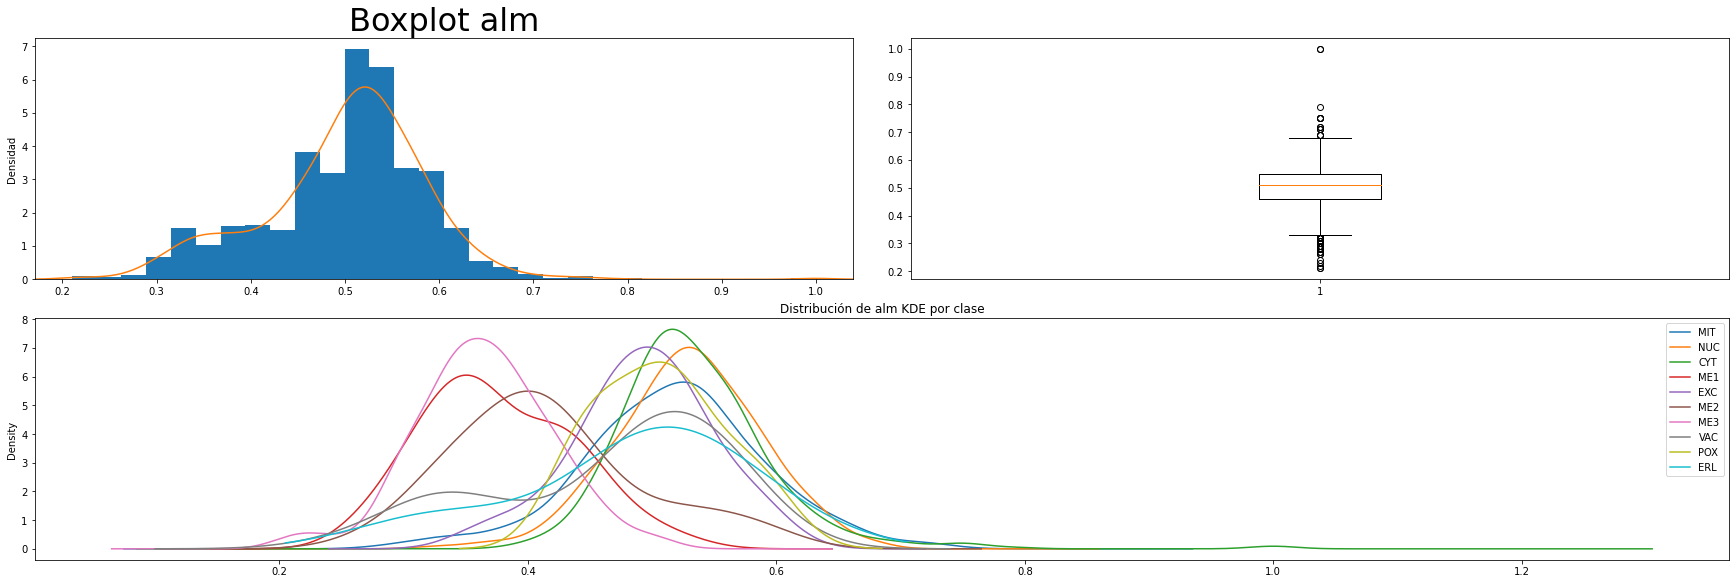

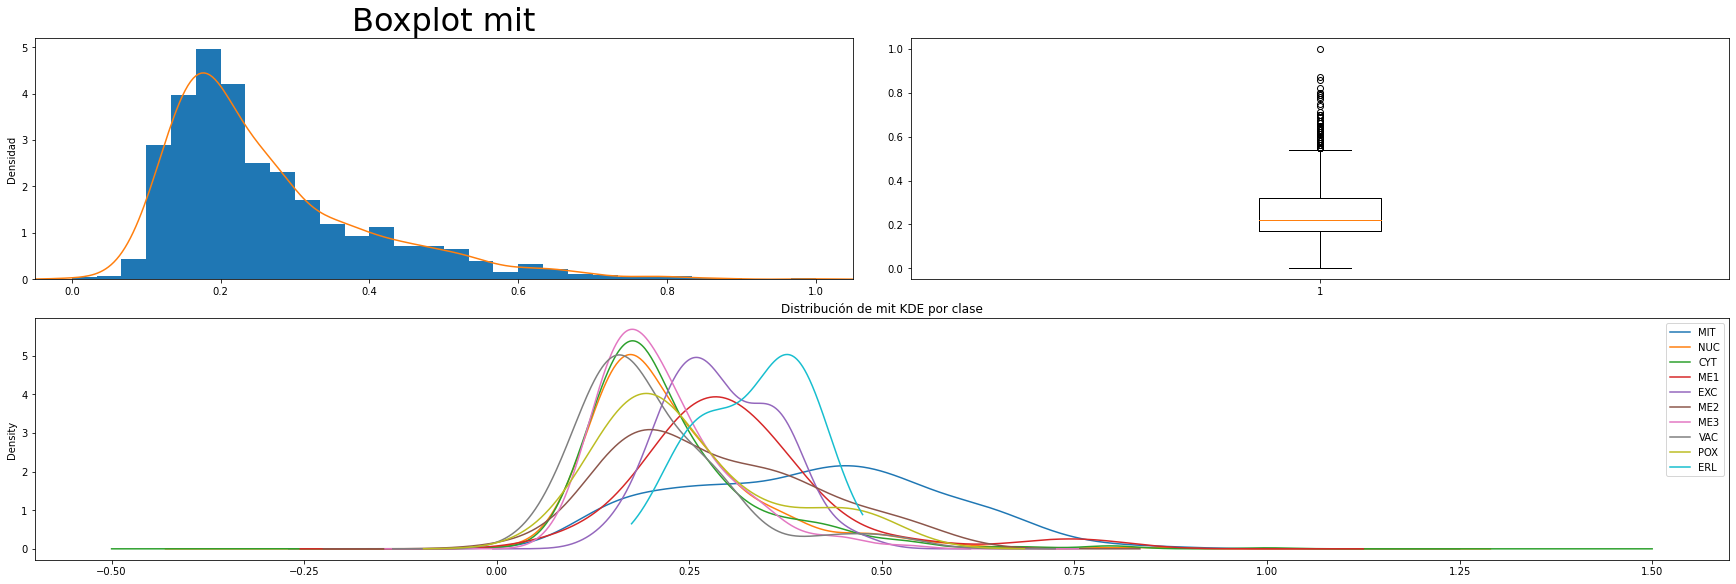

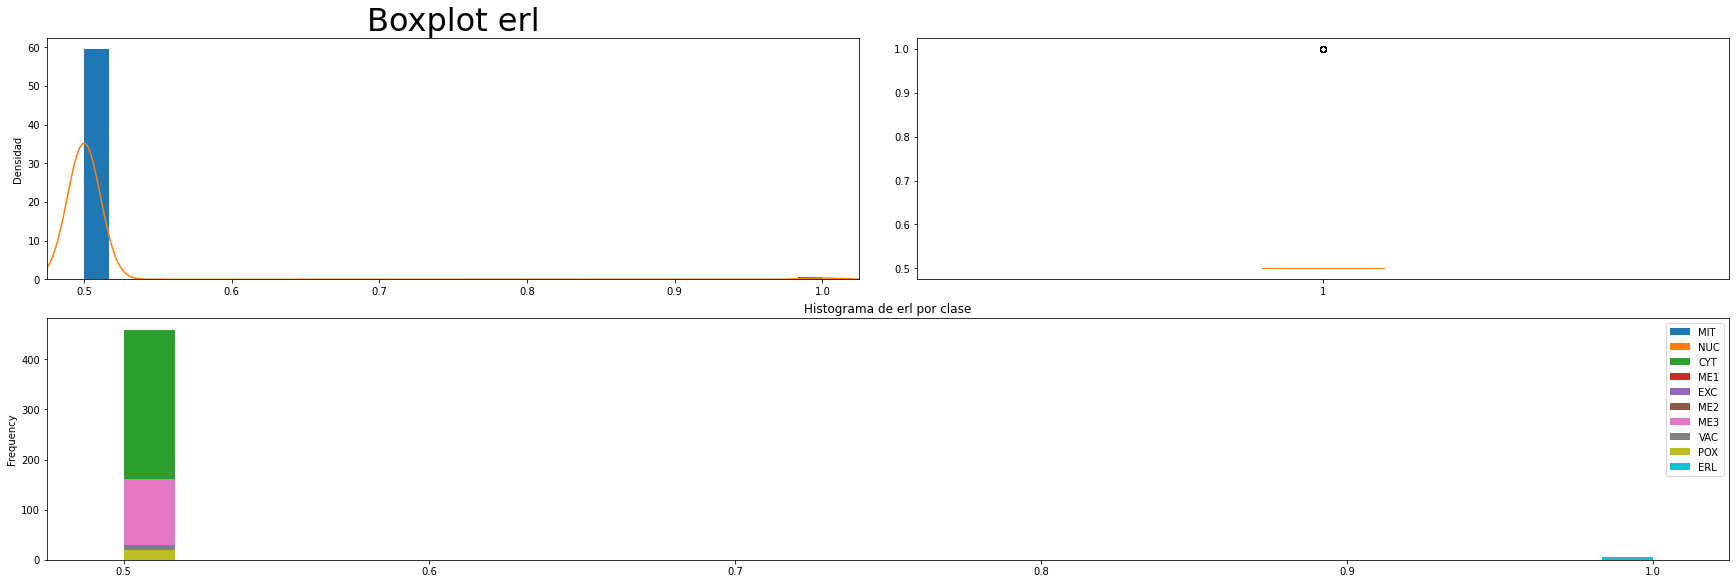

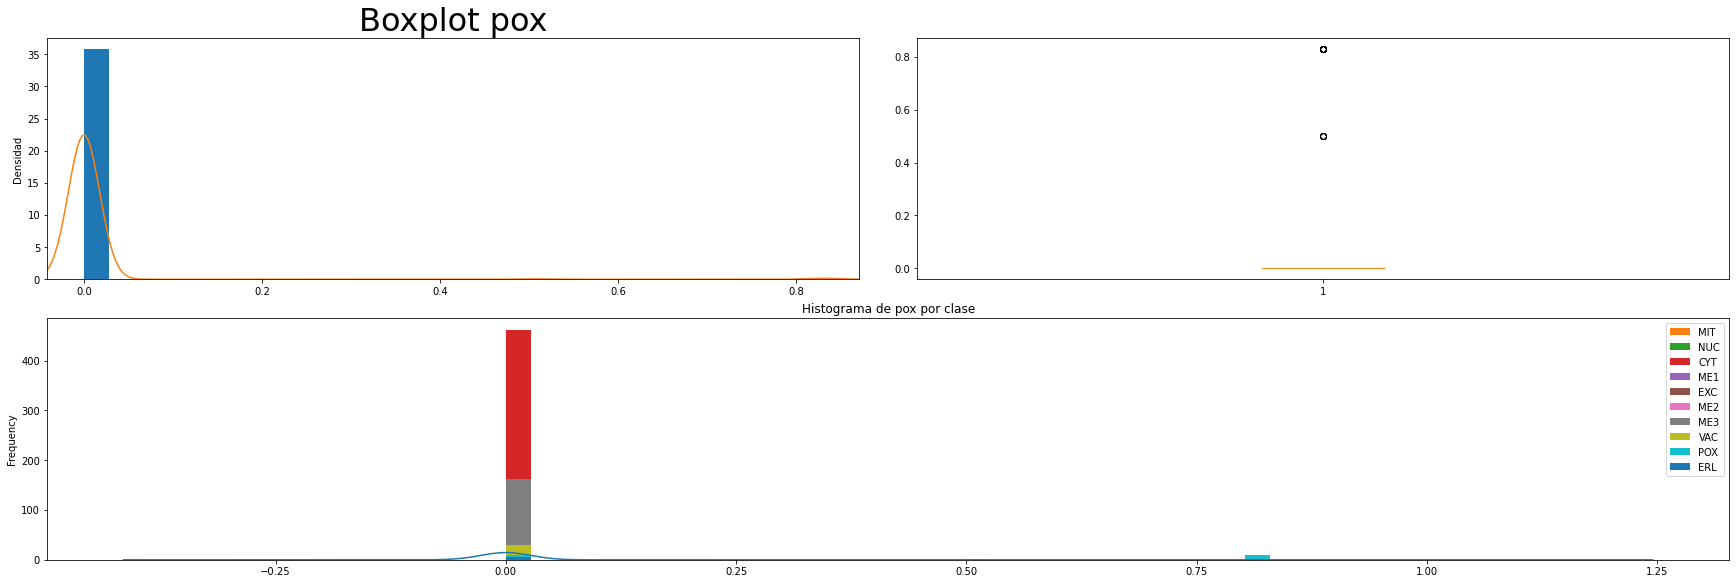

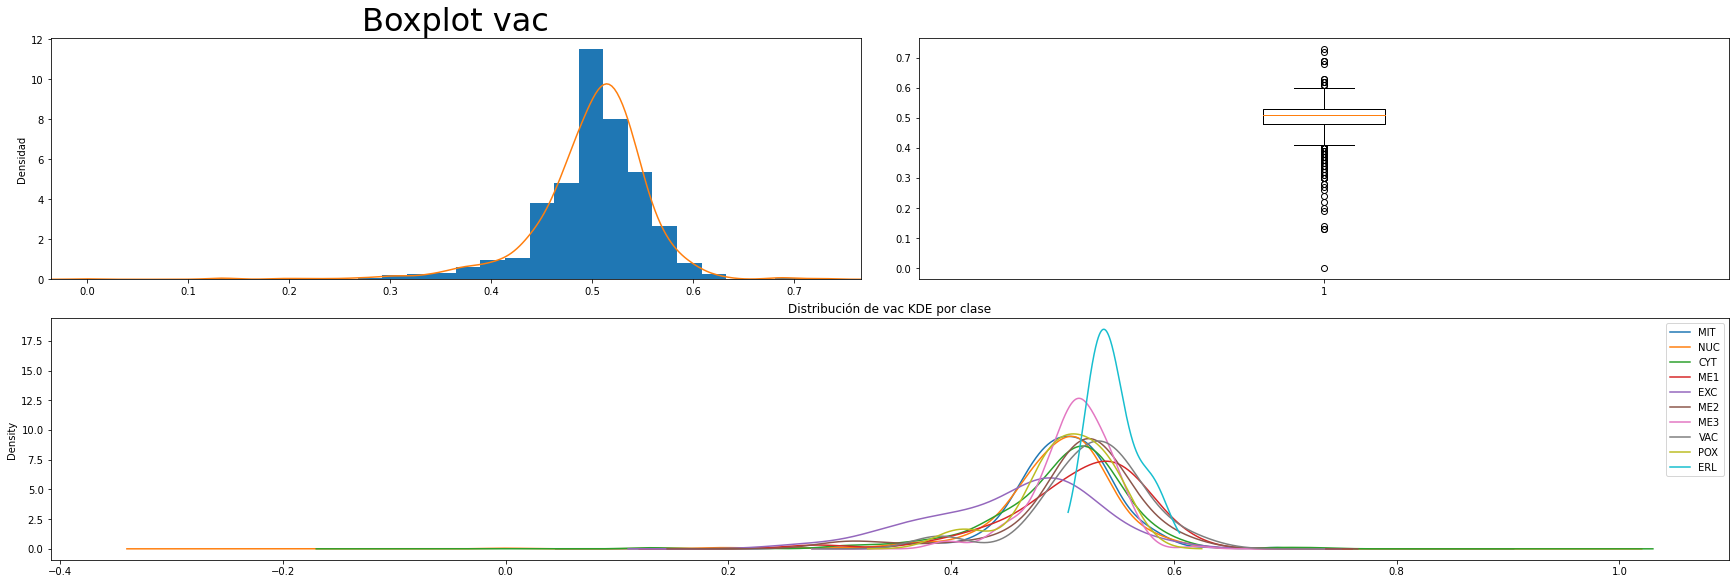

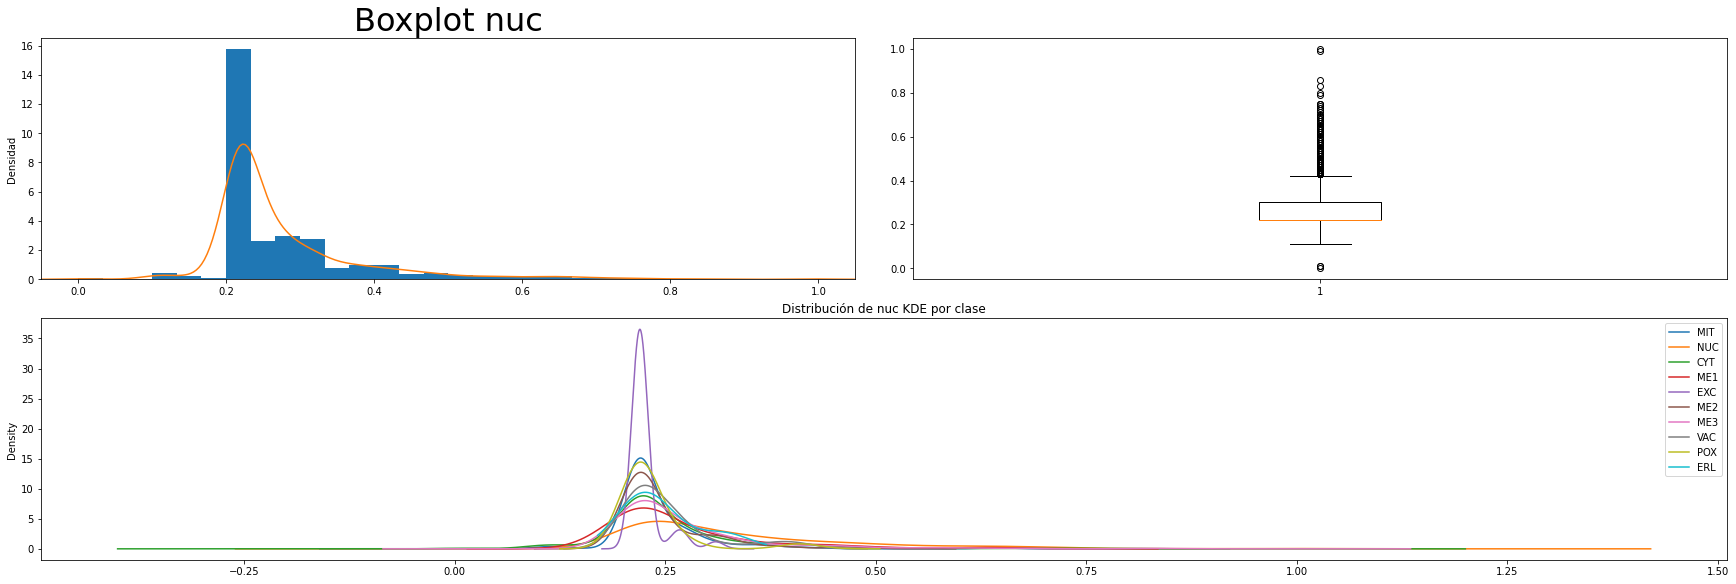

In [6]:
for c in columns:
    nn.compare_param(df,c,30,figsize=(24,8))

Podemos ver que no todas las clases son linealmente separables en cada feature. Por su parte 'erl' y 'pox' tienen distribuciones discretas y luego 'vac' y 'nuc' no nos aportan información caracteristica de cada clase. Más adelante desestimaremos estas variables para ver si mejora el modelo. 

In [7]:
df["erl"].unique()

array([0.5, 1. ])

In [8]:
df["pox"].unique()

array([0.  , 0.5 , 0.83])

Podemos ver a partir de los graficos anteriores y con la función unique, que los valores de erl y pox al ser discretos no pueden ser estimados con una gaussiana y eso se vera reflejado en un error para la clasificación de clases.

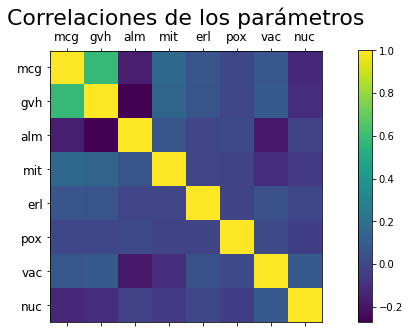

In [9]:
nn.pretty_corr_matrix(df,title="Correlaciones de los parámetros",figsize=(13,5))

Pra ver de una manera distinta la relacione entre features, a continuación vemos la distribución de las clases a partir de 2 parámetros distintos.

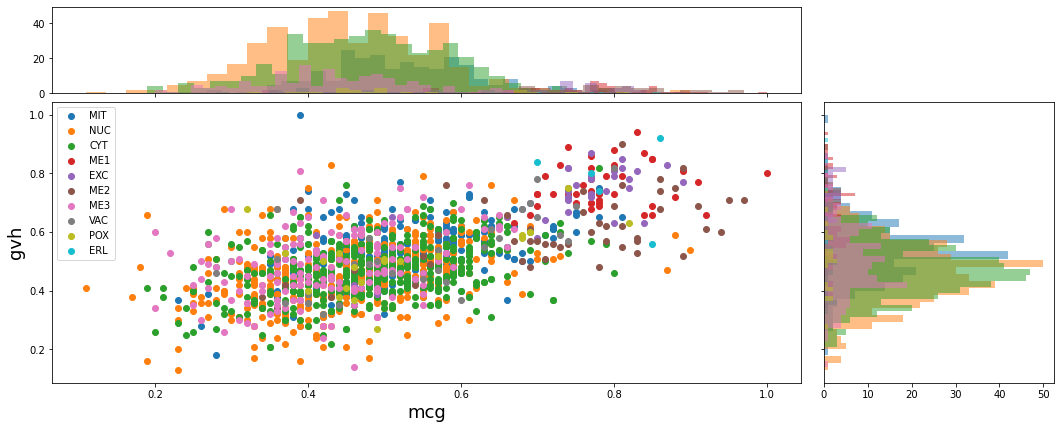

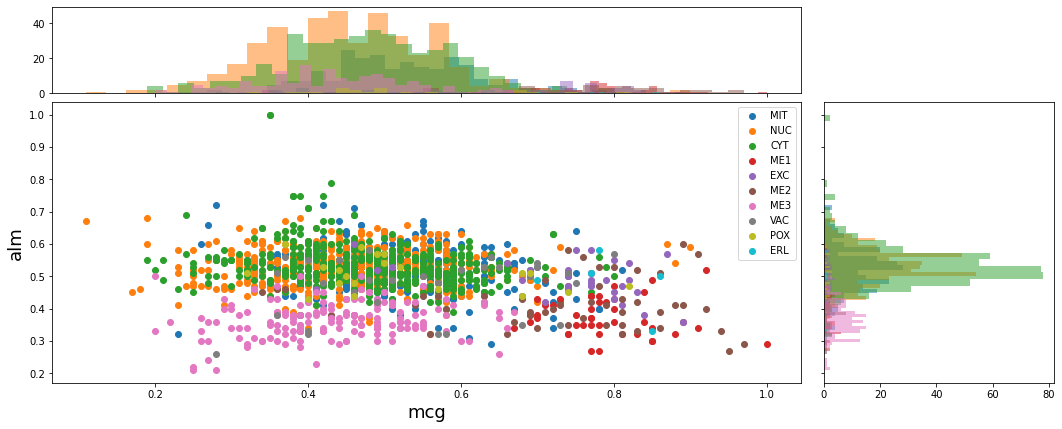

In [10]:
nn.pretty_hist2d(df,df["Class"].drop_duplicates().to_list(),["mcg","gvh"],bins=20)
nn.pretty_hist2d(df,df["Class"].drop_duplicates().to_list(),["mcg","alm"],bins=20)

### Modelo generativo
Se implementaran 2 modelos distintos para el caso de multiclase y binario, el modelo a mano esta basado en la busqueda de la clase con mayor probabilidad a partir del set de training, definido por la siguiente expresión:
\begin{equation}
\widehat{y} = argmax\left [ \prod_{i=1}^{n}P\left ( x_i|y \right )\cdot P(y) \right ]
\end{equation}

Mientras que el segundo modelo esta basado en una implementación con sklearn con selección sigmoidea.

#### Implementación a mano

In [11]:
bad_columns = []
good_columns = [x for x in columns if x not in bad_columns]
train_df, test_df = train_test_split(df.drop(columns=bad_columns), test_size=0.3,random_state=42)
y_test = test_df["Class"].to_list()
x_test = test_df[good_columns].to_numpy()

y_pred = []
for x,y in zip(x_test,y_test):
    y_pred.append(nn.get_yeast_class(x,train_df,print_res=False))

acc, f1_macro, f1_micro, f1_class =nn.show_yeast_metrics(y_test,y_pred)

Accuracy: 48.655%
F1 Macro: 36.619%
F1 Micro: 48.655%
F1 Class: [56.769 55.556 54.545 27.273 74.468 38.462 22.5    0.     0.   ]%


In [12]:
bad_columns = ["erl","pox"]
good_columns = [x for x in columns if x not in bad_columns]
train_df, test_df = train_test_split(df.drop(columns=bad_columns), test_size=0.3,random_state=42)
y_test = test_df["Class"].to_list()
x_test = test_df[good_columns].to_numpy()

y_pred = []
for x,y in zip(x_test,y_test):
    y_pred.append(nn.get_yeast_class(x,train_df,print_res=False))

acc, f1_macro, f1_micro, f1_class =nn.show_yeast_metrics(y_test,y_pred)

Accuracy: 58.072%
F1 Macro: 40.46%
F1 Micro: 58.072%
F1 Class: [61.059  0.    44.444 66.667 44.444 77.358 62.667 47.964  0.     0.   ]%


In [13]:
bad_columns = ["erl","pox","nuc"]
good_columns = [x for x in columns if x not in bad_columns]
train_df, test_df = train_test_split(df.drop(columns=bad_columns), test_size=0.3,random_state=42)
y_test = test_df["Class"].to_list()
x_test = test_df[good_columns].to_numpy()

y_pred = []
for x,y in zip(x_test,y_test):
    y_pred.append(nn.get_yeast_class(x,train_df,print_res=False))

acc, f1_macro, f1_micro, f1_class =nn.show_yeast_metrics(y_test,y_pred)

Accuracy: 56.278%
F1 Macro: 43.197%
F1 Micro: 56.278%
F1 Class: [55.634  0.    57.143 66.667 50.    76.636 57.516 50.19   0.    18.182]%


Podemos ver como al sacar los features de 'erl' y 'pox' mejoro todas las metricas dada su distribución. Pero sacar 'nuc' no tuvo un impacto significativo en las metricas.

#### Implementación con sklearn

In [14]:
bad_columns = ["erl","pox"]
good_columns = [x for x in columns if x not in bad_columns]
train_df, test_df = train_test_split(df.drop(columns=bad_columns), test_size=0.3,random_state=42)
model = Sequential()
model.add(Dense(len(clases), input_shape =(len(good_columns),), activation="sigmoid"))
model.compile( optimizer = SGD(learning_rate=1e-1),
    loss = "binary_crossentropy", metrics = ["accuracy","AUC"])

x_test = test_df[good_columns].values
y_test = to_categorical(list(map(clases.index,test_df["Class"])),num_classes=len(clases))
x_train = train_df[good_columns].values
y_train = to_categorical(list(map(clases.index,train_df["Class"])),num_classes=len(clases))
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_test,y_test),
    epochs=250, batch_size=12,verbose=0)

##### Evaluo Accuracy, F1 y AUC

In [15]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis=1)
y_temp = list(map(clases.index,test_df["Class"]))

acc, f1_macro, f1_micro, f1_class =nn.show_yeast_metrics(y_temp,y_predict)

14/14 [==============================] - 0s 846us/step
Accuracy: 45.291%
F1 Macro: 16.921%
F1 Micro: 45.291%
F1 Class: [50.36  49.802 52.13   0.     0.     0.     0.     0.     0.   ]%


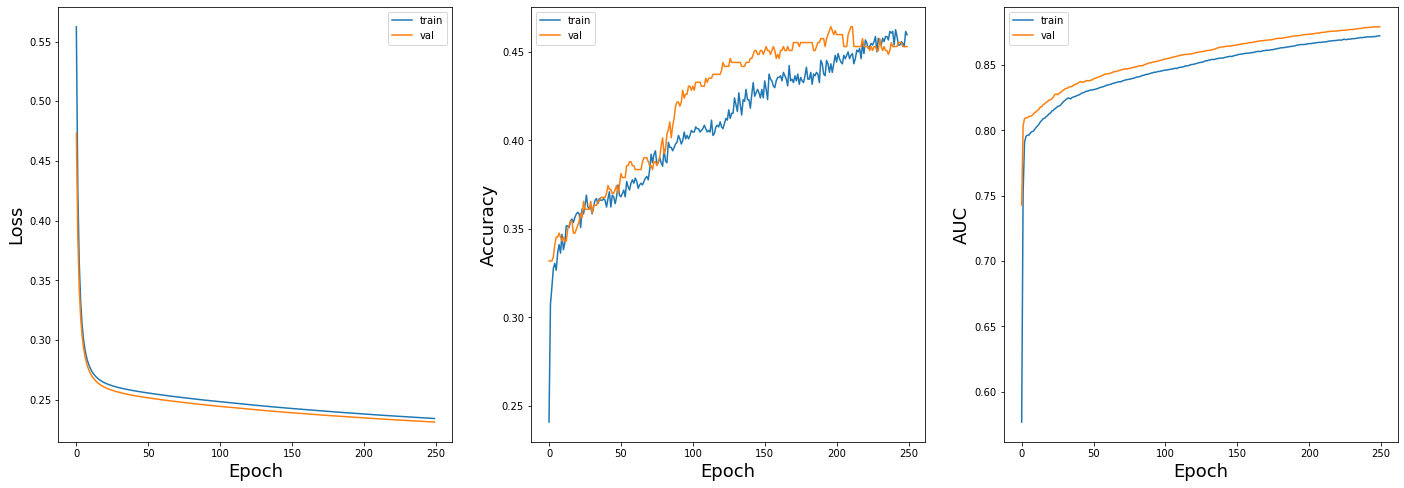

In [16]:
nn.plot_yeast_metrics(history,(24,8))

### Clasificación Binaria

#### Implementación a mano

In [17]:
pos_class, neg_class = ("NUC","CYT")
binary_classes = [pos_class,neg_class]
df_two_classes = pd.concat([df[df["Class"] == pos_class],df[df["Class"] == neg_class]], ignore_index=True)

train, test = train_test_split(df_two_classes.drop(columns=bad_columns), test_size=0.3,random_state=42)
y_test = test["Class"].to_list()
x_test = test[good_columns].to_numpy()
y_train = train["Class"].to_list()
x_train = train[good_columns].to_numpy()

y_pred = []
for x,y in zip(x_test,y_test):
    y_pred.append(nn.get_yeast_class(x,train,print_res=False))

acc, f1_macro, f1_micro, f1_class =nn.show_yeast_metrics(y_test,y_pred)

Accuracy: 59.701%
F1 Macro: 58.687%
F1 Micro: 59.701%
F1 Class: [65.161 52.212]%


In [18]:
roc_auc_score(list(map(binary_classes.index,y_test)),list(map(binary_classes.index,y_pred)))

0.5958785853522696

#### Implementación con sklearn

In [19]:
model = Sequential()
model.add(Dense(2, input_shape =(len(good_columns),), activation="sigmoid"))
model.compile( optimizer = SGD(learning_rate=1e-1),
    loss = "binary_crossentropy", metrics = ["accuracy","AUC"])

x_test = test[good_columns].values
y_test = to_categorical(list(map(binary_classes.index,test["Class"])),num_classes=2)
x_train = train[good_columns].values
y_train = to_categorical(list(map(binary_classes.index,train["Class"])),num_classes=2)

history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_test,y_test),
    epochs=250, batch_size=12,verbose=0)

In [20]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis=1)
y_temp = list(map(binary_classes.index,test["Class"]))

acc, f1_macro, f1_micro, f1_class =nn.show_yeast_metrics(y_temp,y_predict)

9/9 [==============================] - 0s 875us/step
Accuracy: 63.06%
F1 Macro: 62.261%
F1 Micro: 63.06%
F1 Class: [56.769 67.752]%


In [21]:
roc_auc_score(y_temp,y_predict)

0.6295460874408243

9/9 [==============================] - 0s 1000us/step


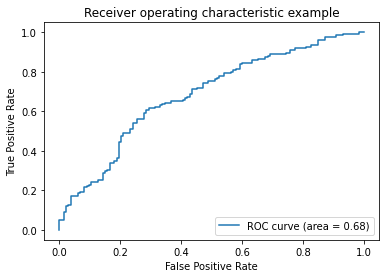

In [22]:
fpr, tpr, threshold = roc_curve(y_temp,model.predict(x_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label=f"ROC curve (area = {np.round(roc_auc,2)})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Vemos que en la implementación binaria se obtuvieron resultados parecidos para en la implementación a mano y con sklearn. Luego el AUC nos da al rededor de 0.6, consecuencia de la sencillez del modelo implementado y la caracteristica de los features al no poder ser linealmente separables.